In [1]:
# !pip install scipy==1.9.1 
# !pip install plotly
# !pip install influxdb-client[ciso]
# !pip install pandas

In [2]:
import scipy
from scipy import signal
from scipy.linalg import _fblas
import numpy as np
from numpy.fft import fft, ifft

In [3]:
import plotly.graph_objects as go

In [4]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd
# from config p key

In [5]:
org = "Artinus"
url = "https://eastus-1.azure.cloud2.influxdata.com"
token = "l7mZ63vVVzgUKP2z6_XMnZWKKJ4VNEeA6hSMPbqj_-z2l86OpSV8RA9EMzwoTPZSgg9KZzA8R6AkwztiBHgT6A=="

client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)


In [6]:
query_api = client.query_api()
varss = ['close']
df_ohlc = pd.DataFrame(columns=varss)
for var in varss:
    query = f"""
        from(bucket: "DukascopyTest")
        |> range(start: 2022-09-09T17:14:06.790Z, stop: 2022-09-10T17:14:06.790Z)
        |> filter(fn: (r) => r._measurement == "bid_{var}")
        |> filter(fn: (r) => r.symbol == "EUR/USD")
        |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
        |> map(fn: (r) => ({{r with {var}: r.price}}))
        """
    tables = query_api.query(query, org=org)
    df_var = query_api.query_data_frame(query, org=org)
    df_ohlc[var] = df_var[var]
df_ohlc['_time'] = df_var['_time']
df_ohlc['symbol'] = df_var['symbol']
#     display(df_var[var])


In [7]:
y = df_ohlc['close'].to_numpy()

# normalize not required because high freq are removed
# y = y-np.mean(y) 
# y = y/max(abs(y))


In [8]:

# band_width = 0.05
# lowcut = freq1*(1-band_width/2)
def zig(freq = 0.1, extrema_radius = 2):


    # filter y with low pass filter
    b, a = signal.butter(2, freq, fs=1, btype='low', analog=False)
    y_filt = signal.filtfilt(b, a, y)
    deriv = y_filt[1:]-y_filt[:-1]

    # find lowest value extrema_radius away from all troughs in the filtered signal 
    troughs = np.where((deriv[1:]>0) &(deriv[:-1]<=0))[0]+1  # +1 is to account for data that goes missing when doing [1:] 

    trough_lows = []
    for n in troughs:
        trough_index, trough_price = None, None
        for index, price in enumerate(y[max(n-extrema_radius,0):min(extrema_radius+n+1,len(y))], n-extrema_radius):
            if trough_index is None or trough_price > price:
                trough_index, trough_price = index, price

        trough_lows.append(trough_index)

    # find higest value extrema_radius away from all peaks in the filtered signal 
    peaks = np.where((deriv[1:]<0) &(deriv[:-1]>=0))[0]+1  # +1 is to account for data that goes missing when doing [1:] 

    peak_highs = []
    for n in peaks:
        peak_index, peak_price = None, None
        for index, price in enumerate(y[max(n-extrema_radius,0):min(n+1+extrema_radius,len(y))], n-extrema_radius):
            if peak_index is None or peak_price < price:
                peak_index, peak_price = index, price
        peak_highs.append(peak_index)



    zig = trough_lows+peak_highs
    zig.sort()
    
    return zig, peak_highs, trough_lows


zig, peak_highs, trough_lows = zig()

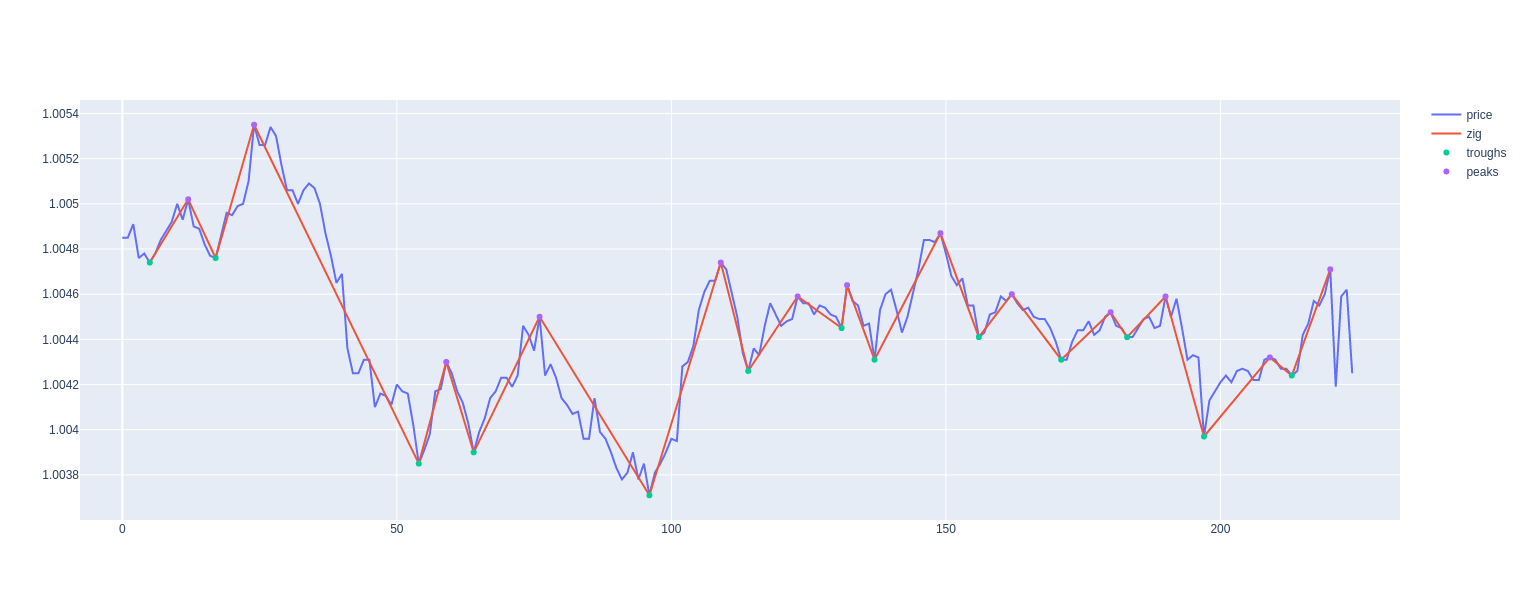

In [9]:

fig = go.Figure()
fig = fig.add_trace(go.Scatter(y=y, name= 'price'))
# fig = fig.add_trace(go.Scatter(y=y_filt, name= 'filtered'))
# fig = fig.add_trace(go.Scatter(y=deriv, name= 'deriv'))

fig = fig.add_trace(go.Scatter(x=zig, y = y[zig], name= 'zig', mode='lines'))

fig = fig.add_trace(go.Scatter(x=trough_lows, y = y[trough_lows], name= 'troughs', mode='markers'))
fig = fig.add_trace(go.Scatter(x=peak_highs, y = y[peak_highs], name= 'peaks', mode='markers'))


fig.update_layout(
    autosize=False,
    height=600,
    width=1500,
)

fig.show()


# Lower Low Testing With Zig Output

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.signal import argrelextrema
from collections import deque
def getLowerLows(data: np.array, order=2, K=2):
    # Get lows
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    # Ensure consecutive lows are lower than previous lows
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if lows[i] > lows[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())

    return extrema


In [49]:
getLowerLows(y[trough_lows])

[]

In [32]:
trough_lows[2:14]

[54, 64, 96, 114, 131, 137, 156, 171, 183, 197, 213]

In [27]:
y[trough_lows[4:10]]

array([1.00371, 1.00426, 1.00445, 1.00431, 1.00441, 1.00431])